In [ ]:
# default_exp models.ph

# Piecewise Hazard Model
> How to estimate the Piecewise Hazard estimator.

In this module we assume that during a given time period the hazard is constant.

In [ ]:
# export
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

torch.Tensor.ndim = property(lambda x: x.dim())

In [ ]:
# hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# export
class PieceWiseHazard(nn.Module):
    """
    Piecewise Hazard where the hazard is constant between breakpoints.
    parameters:
    - breakpoints: time points where hazard would change
    - max_t: maximum point of time to plot to.
    """
    def __init__(self, breakpoints, widths, **kwargs):
        super().__init__()
        self.logλ = nn.Parameter(torch.randn(len(breakpoints)-1, 1))
        self.register_buffer('breakpoints', torch.Tensor(breakpoints[:-1]))
#         bounded_bp = [0] + breakpoints.tolist() + [max_t]
        self.register_buffer('widths', torch.Tensor(widths)[:,None])
        self.prepend_zero = nn.ConstantPad2d((0,0,1,0), 0)
        
    def cumulative_hazard(self, t, t_section):
        """
        Integral of hazard wrt time.
        """
        λ = torch.exp(self.logλ)

        # cumulative hazard 
        cum_hazard = λ * self.widths
        cum_hazard = cum_hazard.cumsum(0)
        cum_hazard = self.prepend_zero(cum_hazard)
        cum_hazard_sec = cum_hazard[t_section]
        
        δ_t = t - self.breakpoints[t_section][:,None]
        
        return cum_hazard_sec + λ[t_section] * δ_t
        
    def forward(self, t, t_section, *args):
        return self.logλ[t_section], self.cumulative_hazard(t, t_section)
    
    def survival_function(self, t):
        with torch.no_grad():
            # get the times and time sections for survival function
            breakpoints = self.breakpoints[1:].cpu().numpy()
            t_sec_query = np.searchsorted(breakpoints, t)
            # convert to pytorch tensors
            t_query = torch.Tensor(t)[:,None]
            t_sec_query = torch.LongTensor(t_sec_query)

            # calculate cumulative hazard according to above
            Λ = self.cumulative_hazard(t_query, t_sec_query)
            return torch.exp(-Λ)
        
    def hazard(self):
        with torch.no_grad():
            width = self.widths.squeeze()
            x = self.breakpoints.squeeze()
            λ = torch.exp(self.logλ)
            return x, width, λ.squeeze()
            
    def plot_survival_function(self, t):
        s = self.survival_function(t)
        # plot
        plt.figure(figsize=(12,5))
        plt.plot(t, s)
        plt.xlabel('Time')
        plt.ylabel('Survival Probability')
        plt.show()
        
    def plot_hazard(self):
        """
        Plot base hazard
        """
        x, width, y = self.hazard()
        # plot
        plt.figure(figsize=(12,5))
        plt.bar(x, y, width, align='edge')
        plt.ylabel('λ')
        plt.xlabel('t')
        plt.show()

In [ ]:
# hide
from torchlife.data import create_db
import pandas as pd

url = "https://raw.githubusercontent.com/CamDavidsonPilon/lifelines/master/lifelines/datasets/rossi.csv"
df = pd.read_csv(url)
df.head()

,week,arrest,fin,age,race,wexp,mar,paro,prio
0,20,1,0,27,1,0,0,1,3
1,17,1,0,18,1,0,0,1,8
2,25,1,0,19,0,1,0,1,13
3,52,0,1,23,1,1,1,1,1
4,52,0,0,19,0,1,0,1,3


epoch,train_loss,valid_loss,time
0,192.045792,#na#,00:00
1,192.858414,#na#,00:00
2,192.781830,#na#,00:00
3,192.886154,#na#,00:00
4,193.222458,#na#,00:00
5,193.374252,#na#,00:00
6,193.364075,#na#,00:00
7,193.393280,#na#,00:00
8,193.365829,#na#,00:00
9,193.384064,#na#,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


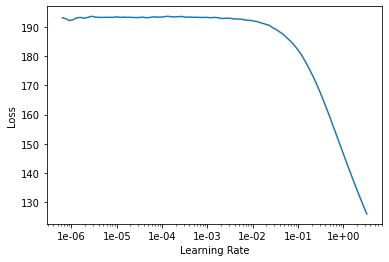

In [ ]:
# hide
from fastai.basics import Learner
from torchlife.losses import hazard_loss
from torchlife.data import get_breakpoints, create_db

df.rename(columns={'week':'t', 'arrest':'e'}, inplace=True)

# event_times = df.loc[df['e']==1, 't'].values
# breakpoints = np.percentile(event_times, [20, 40, 60, 80])
# print(breakpoints)
breakpoints, widths = get_breakpoints(df)
db = create_db(df, breakpoints)

model = PieceWiseHazard(breakpoints, widths)
learner = Learner(db, model, loss_func=hazard_loss)
learner.lr_find()
learner.recorder.plot()

In [ ]:
# hide
epochs = 20
learner.fit(epochs, lr=1)

epoch,train_loss,valid_loss,time
0,96.886230,14.265872,00:00
1,51.421303,3.611621,00:00
2,34.143570,2.294735,00:00
3,25.292212,2.105830,00:00
4,19.949295,2.112500,00:00
5,16.402908,2.146816,00:00
6,13.884984,2.171907,00:00
7,12.012718,2.181776,00:00
8,10.551715,2.176518,00:00
9,9.397611,2.160330,00:00


## Plot Hazard Functions

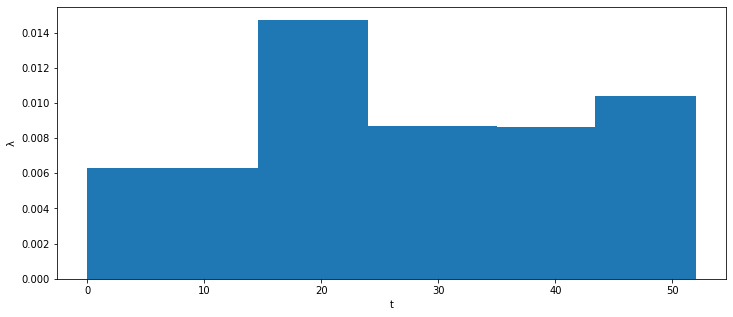

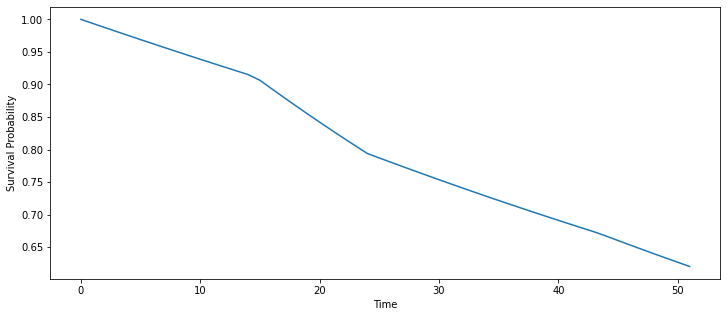

In [ ]:
learner.model.plot_hazard()
learner.model.plot_survival_function(np.arange(df['t'].max()))

In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_index.ipynb.
Converted 10_SAT.ipynb.
Converted 20_KaplanMeier.ipynb.
Converted 50_hazard.ipynb.
Converted 55_hazard.PiecewiseHazard.ipynb.
Converted 59_hazard.Cox.ipynb.
Converted 60_AFT_models.ipynb.
Converted 65_AFT_error_distributions.ipynb.
Converted 80_data.ipynb.
Converted 90_model.ipynb.
Converted 95_Losses.ipynb.
